In [10]:
# ===================================================================
# CLARITy - PyTorch Training Script (DenseNet121)
# ===================================================================

import warnings
warnings.filterwarnings('ignore')

import torch, torch.nn as nn, torch.optim as optim
import torchvision.models as models
import torchvision.transforms as transforms
from torch.utils.data import Dataset, DataLoader
from torch.optim.lr_scheduler import ReduceLROnPlateau
import torch.nn.functional as F

import pandas as pd
import numpy as np
from PIL import Image
from pathlib import Path
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score, f1_score
import matplotlib.pyplot as plt
from tqdm import tqdm

import json

In [2]:
# ---------------- CONFIG ----------------
BASE_PATH    = Path(r"D:/Projects/CLARITY/Model/Dataset/archive")  # update
CSV_FILE     = BASE_PATH / "Data_Entry_2017.csv"
SAVE_PATH    = Path("./saved_model")
SAVE_PATH.mkdir(exist_ok=True)

IMG_SIZE     = 224
BATCH_SIZE   = 16
EPOCHS       = 30
LR           = 1e-4
DEVICE       = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Device:", DEVICE)

# ---------------- LOAD CSV ----------------
df = pd.read_csv(CSV_FILE)

# Map image paths
image_map = {}
for folder in BASE_PATH.iterdir():
    if folder.is_dir() and folder.name.startswith('images_'):
        for img in (folder/"images").glob("*.png"):
            image_map[img.name] = img

df = df[df['Image Index'].isin(image_map)].copy()
df['full_path'] = df['Image Index'].map(image_map)

# Multi-labels
diseases = ['No Finding','Atelectasis','Cardiomegaly','Effusion','Infiltration',
            'Mass','Nodule','Pneumonia','Pneumothorax','Consolidation','Edema',
            'Emphysema','Fibrosis','Pleural_Thickening','Hernia']

df['labels'] = df['Finding Labels'].apply(lambda s: [1 if d in s.split("|") else 0 for d in diseases])

# ---------------- SPLIT DATA ----------------
train_df, temp_df = train_test_split(df, test_size=0.2, random_state=42)
val_df, test_df   = train_test_split(temp_df, test_size=0.5, random_state=42)
train_df, val_df, test_df = train_df.reset_index(drop=True), val_df.reset_index(drop=True), test_df.reset_index(drop=True)
print("Train:", len(train_df), "Val:", len(val_df), "Test:", len(test_df))

Device: cuda
Train: 89696 Val: 11212 Test: 11212


In [3]:
# ---------------- DATASET ----------------
class XrayDataset(Dataset):
    def __init__(self, df, transform):
        self.df = df
        self.transform = transform
    def __len__(self):
        return len(self.df)
    def __getitem__(self, idx):
        row = self.df.iloc[idx]
        img = Image.open(row['full_path']).convert('RGB')
        img = self.transform(img)
        label = torch.FloatTensor(row['labels'])
        return img, label

In [4]:
# ---------------- TRANSFORMS ----------------
train_tf = transforms.Compose([
    transforms.Resize((IMG_SIZE, IMG_SIZE)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(10),
    transforms.ColorJitter(0.1,0.1,0.1,0.1),
    transforms.ToTensor(),
    transforms.Normalize([0.485,0.456,0.406],[0.229,0.224,0.225])
])
test_tf = transforms.Compose([
    transforms.Resize((IMG_SIZE, IMG_SIZE)),
    transforms.ToTensor(),
    transforms.Normalize([0.485,0.456,0.406],[0.229,0.224,0.225])
])

train_ds = XrayDataset(train_df, train_tf)
val_ds   = XrayDataset(val_df,   test_tf)
test_ds  = XrayDataset(test_df,  test_tf)

train_loader = DataLoader(train_ds, batch_size=BATCH_SIZE, shuffle=True, num_workers=0)
val_loader   = DataLoader(val_ds,   batch_size=BATCH_SIZE, shuffle=False, num_workers=0)
test_loader  = DataLoader(test_ds,  batch_size=BATCH_SIZE, shuffle=False, num_workers=0)

In [5]:
class FocalLoss(nn.Module):
    def __init__(self, alpha=1, gamma=2, logits=True, reduce=True):
        super(FocalLoss, self).__init__()
        self.alpha = alpha
        self.gamma = gamma
        self.logits = logits
        self.reduce = reduce

    def forward(self, inputs, targets):
        if self.logits:
            BCE_loss = F.binary_cross_entropy_with_logits(inputs, targets, reduction='none')
        else:
            BCE_loss = F.binary_cross_entropy(inputs, targets, reduction='none')
        pt = torch.exp(-BCE_loss)
        F_loss = self.alpha * (1 - pt) ** self.gamma * BCE_loss
        if self.reduce:
            return torch.mean(F_loss)
        else:
            return F_loss

In [6]:
# ---------------- MODEL ----------------
model = models.densenet121(weights='DEFAULT')
model.classifier = nn.Linear(model.classifier.in_features, len(diseases))
model = model.to(DEVICE)

# ---------------- LOSS & OPTIMIZER ----------------
label_arr = np.vstack(df['labels'])
pos_weight = torch.FloatTensor(label_arr.sum(axis=0).max()/(label_arr.sum(axis=0)+1)).to(DEVICE)
criterion = FocalLoss()
#criterion = nn.BCEWithLogitsLoss(pos_weight=pos_weight)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)
scheduler = ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=5)

In [9]:
# ---------------- TRAINING ----------------
history = {'train_loss':[], 'val_loss':[], 'val_auc':[]}
best_auc = 0

for epoch in range(EPOCHS):
    model.train()
    running_loss = 0
    running_auc  = 0
    for imgs, lbls in tqdm(train_loader, desc=f"Epoch {epoch+1}/{EPOCHS} [Train]"):
        imgs, lbls = imgs.to(DEVICE), lbls.to(DEVICE)
        optimizer.zero_grad()
        out = model(imgs)
        loss = criterion(out, lbls)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()

        # batch AUC
        pred = torch.sigmoid(out).detach().cpu().numpy()
        true = lbls.cpu().numpy()
        batch_auc = np.mean([roc_auc_score(true[:,i], pred[:,i]) if true[:,i].sum()>0 else 0.5 for i in range(len(diseases))])
        running_auc += batch_auc

    train_loss = running_loss / len(train_loader)
    train_auc  = running_auc / len(train_loader)

    # Validate
    model.eval()
    val_loss, val_preds, val_true = 0, [], []
    with torch.no_grad():
        for imgs, lbls in val_loader:
            imgs, lbls = imgs.to(DEVICE), lbls.to(DEVICE)
            out = model(imgs)
            val_loss += criterion(out, lbls).item()
            val_preds.append(torch.sigmoid(out).cpu().numpy())
            val_true.append(lbls.cpu().numpy())
    val_loss /= len(val_loader)
    val_preds = np.vstack(val_preds)
    val_true  = np.vstack(val_true)
    val_auc = np.mean([roc_auc_score(val_true[:,i], val_preds[:,i]) if val_true[:,i].sum()>0 else 0.5 for i in range(len(diseases))])

    history['train_loss'].append(train_loss)
    history['val_loss'].append(val_loss)
    history['val_auc'].append(val_auc)

    print(f"Epoch {epoch+1} -> Train Loss: {train_loss:.4f}, Train AUC: {train_auc:.4f} | Val Loss: {val_loss:.4f}, Val AUC: {val_auc:.4f}")

    # Save best model
    if val_auc > best_auc:
        best_auc = val_auc
        torch.save(model.state_dict(), SAVE_PATH/"best_model.pth")
        print(f" Saved best model with Val AUC: {best_auc:.4f}")

    scheduler.step(val_loss)

Epoch 1/30 [Train]: 100%|██████████████████████████████████████████████████████████| 5606/5606 [32:21<00:00,  2.89it/s]


Epoch 1 -> Train Loss: 0.0520, Train AUC: 0.6349 | Val Loss: 0.0497, Val AUC: 0.8083
 Saved best model with Val AUC: 0.8083


Epoch 2/30 [Train]: 100%|██████████████████████████████████████████████████████████| 5606/5606 [32:17<00:00,  2.89it/s]


Epoch 2 -> Train Loss: 0.0490, Train AUC: 0.6545 | Val Loss: 0.0480, Val AUC: 0.8246
 Saved best model with Val AUC: 0.8246


Epoch 3/30 [Train]: 100%|██████████████████████████████████████████████████████████| 5606/5606 [32:14<00:00,  2.90it/s]


Epoch 3 -> Train Loss: 0.0479, Train AUC: 0.6606 | Val Loss: 0.0475, Val AUC: 0.8287
 Saved best model with Val AUC: 0.8287


Epoch 4/30 [Train]: 100%|██████████████████████████████████████████████████████████| 5606/5606 [32:15<00:00,  2.90it/s]


Epoch 4 -> Train Loss: 0.0471, Train AUC: 0.6646 | Val Loss: 0.0471, Val AUC: 0.8364
 Saved best model with Val AUC: 0.8364


Epoch 5/30 [Train]: 100%|██████████████████████████████████████████████████████████| 5606/5606 [32:17<00:00,  2.89it/s]


Epoch 5 -> Train Loss: 0.0464, Train AUC: 0.6692 | Val Loss: 0.0474, Val AUC: 0.8300


Epoch 6/30 [Train]: 100%|██████████████████████████████████████████████████████████| 5606/5606 [32:17<00:00,  2.89it/s]


Epoch 6 -> Train Loss: 0.0458, Train AUC: 0.6707 | Val Loss: 0.0468, Val AUC: 0.8392
 Saved best model with Val AUC: 0.8392


Epoch 7/30 [Train]: 100%|██████████████████████████████████████████████████████████| 5606/5606 [32:15<00:00,  2.90it/s]


Epoch 7 -> Train Loss: 0.0451, Train AUC: 0.6741 | Val Loss: 0.0471, Val AUC: 0.8376


Epoch 8/30 [Train]: 100%|██████████████████████████████████████████████████████████| 5606/5606 [32:17<00:00,  2.89it/s]


Epoch 8 -> Train Loss: 0.0445, Train AUC: 0.6776 | Val Loss: 0.0465, Val AUC: 0.8431
 Saved best model with Val AUC: 0.8431


Epoch 9/30 [Train]: 100%|██████████████████████████████████████████████████████████| 5606/5606 [32:17<00:00,  2.89it/s]


Epoch 9 -> Train Loss: 0.0438, Train AUC: 0.6806 | Val Loss: 0.0467, Val AUC: 0.8383


Epoch 10/30 [Train]: 100%|█████████████████████████████████████████████████████████| 5606/5606 [32:16<00:00,  2.89it/s]


Epoch 10 -> Train Loss: 0.0432, Train AUC: 0.6830 | Val Loss: 0.0472, Val AUC: 0.8338


Epoch 11/30 [Train]: 100%|█████████████████████████████████████████████████████████| 5606/5606 [32:17<00:00,  2.89it/s]


Epoch 11 -> Train Loss: 0.0424, Train AUC: 0.6862 | Val Loss: 0.0476, Val AUC: 0.8358


Epoch 12/30 [Train]: 100%|█████████████████████████████████████████████████████████| 5606/5606 [32:19<00:00,  2.89it/s]


Epoch 12 -> Train Loss: 0.0416, Train AUC: 0.6896 | Val Loss: 0.0482, Val AUC: 0.8337


Epoch 13/30 [Train]: 100%|█████████████████████████████████████████████████████████| 5606/5606 [32:19<00:00,  2.89it/s]


Epoch 13 -> Train Loss: 0.0407, Train AUC: 0.6941 | Val Loss: 0.0485, Val AUC: 0.8339


Epoch 14/30 [Train]: 100%|█████████████████████████████████████████████████████████| 5606/5606 [32:34<00:00,  2.87it/s]


Epoch 14 -> Train Loss: 0.0398, Train AUC: 0.6969 | Val Loss: 0.0491, Val AUC: 0.8256


Epoch 15/30 [Train]: 100%|█████████████████████████████████████████████████████████| 5606/5606 [32:38<00:00,  2.86it/s]


Epoch 15 -> Train Loss: 0.0364, Train AUC: nan | Val Loss: 0.0519, Val AUC: 0.8253


Epoch 16/30 [Train]: 100%|█████████████████████████████████████████████████████████| 5606/5606 [32:37<00:00,  2.86it/s]


Epoch 16 -> Train Loss: 0.0344, Train AUC: nan | Val Loss: 0.0536, Val AUC: 0.8207


Epoch 17/30 [Train]: 100%|█████████████████████████████████████████████████████████| 5606/5606 [32:26<00:00,  2.88it/s]


Epoch 17 -> Train Loss: 0.0330, Train AUC: 0.7179 | Val Loss: 0.0545, Val AUC: 0.8197


Epoch 18/30 [Train]: 100%|█████████████████████████████████████████████████████████| 5606/5606 [32:19<00:00,  2.89it/s]


Epoch 18 -> Train Loss: 0.0317, Train AUC: 0.7211 | Val Loss: 0.0579, Val AUC: 0.8172


Epoch 19/30 [Train]: 100%|█████████████████████████████████████████████████████████| 5606/5606 [32:22<00:00,  2.89it/s]


Epoch 19 -> Train Loss: 0.0303, Train AUC: 0.7238 | Val Loss: 0.0583, Val AUC: 0.8106


Epoch 20/30 [Train]: 100%|█████████████████████████████████████████████████████████| 5606/5606 [32:19<00:00,  2.89it/s]


Epoch 20 -> Train Loss: 0.0292, Train AUC: nan | Val Loss: 0.0630, Val AUC: 0.8094


Epoch 21/30 [Train]: 100%|█████████████████████████████████████████████████████████| 5606/5606 [32:29<00:00,  2.88it/s]


Epoch 21 -> Train Loss: 0.0258, Train AUC: 0.7335 | Val Loss: 0.0647, Val AUC: 0.8047


Epoch 22/30 [Train]: 100%|█████████████████████████████████████████████████████████| 5606/5606 [32:27<00:00,  2.88it/s]


Epoch 22 -> Train Loss: 0.0246, Train AUC: 0.7352 | Val Loss: 0.0685, Val AUC: 0.8062


Epoch 23/30 [Train]: 100%|█████████████████████████████████████████████████████████| 5606/5606 [32:28<00:00,  2.88it/s]


Epoch 23 -> Train Loss: 0.0234, Train AUC: nan | Val Loss: 0.0711, Val AUC: 0.8040


Epoch 24/30 [Train]: 100%|█████████████████████████████████████████████████████████| 5606/5606 [32:27<00:00,  2.88it/s]


Epoch 24 -> Train Loss: 0.0225, Train AUC: 0.7388 | Val Loss: 0.0713, Val AUC: 0.7999


Epoch 25/30 [Train]: 100%|█████████████████████████████████████████████████████████| 5606/5606 [32:27<00:00,  2.88it/s]


Epoch 25 -> Train Loss: 0.0216, Train AUC: 0.7402 | Val Loss: 0.0750, Val AUC: 0.7977


Epoch 26/30 [Train]: 100%|█████████████████████████████████████████████████████████| 5606/5606 [32:21<00:00,  2.89it/s]


Epoch 26 -> Train Loss: 0.0208, Train AUC: 0.7412 | Val Loss: 0.0784, Val AUC: 0.7996


Epoch 27/30 [Train]: 100%|█████████████████████████████████████████████████████████| 5606/5606 [32:23<00:00,  2.88it/s]


Epoch 27 -> Train Loss: 0.0189, Train AUC: nan | Val Loss: 0.0814, Val AUC: 0.7987


Epoch 28/30 [Train]: 100%|█████████████████████████████████████████████████████████| 5606/5606 [32:20<00:00,  2.89it/s]


Epoch 28 -> Train Loss: 0.0181, Train AUC: 0.7452 | Val Loss: 0.0837, Val AUC: 0.7950


Epoch 29/30 [Train]: 100%|█████████████████████████████████████████████████████████| 5606/5606 [32:19<00:00,  2.89it/s]


Epoch 29 -> Train Loss: 0.0175, Train AUC: 0.7460 | Val Loss: 0.0848, Val AUC: 0.7960


Epoch 30/30 [Train]: 100%|█████████████████████████████████████████████████████████| 5606/5606 [32:11<00:00,  2.90it/s]


Epoch 30 -> Train Loss: 0.0171, Train AUC: nan | Val Loss: 0.0865, Val AUC: 0.7952


In [11]:
with open("./saved_model/history.json","w") as f:
    json.dump(history,f)

In [12]:
with open("./saved_model/history.json", "r") as f:
    history = json.load(f)

In [13]:
# ---------------- TEST EVALUATION ----------------
model.load_state_dict(torch.load(SAVE_PATH/"best_model.pth"))
model.eval()
test_preds, test_true = [], []
with torch.no_grad():
    for imgs, lbls in tqdm(test_loader, desc="Test"):
        imgs = imgs.to(DEVICE)
        out = model(imgs)
        test_preds.append(torch.sigmoid(out).cpu().numpy())
        test_true.append(lbls.numpy())

test_preds = np.vstack(test_preds)
test_true  = np.vstack(test_true)
test_auc = np.mean([roc_auc_score(test_true[:,i], test_preds[:,i]) if test_true[:,i].sum()>0 else 0.5 for i in range(len(diseases))])
print("Test mean AUC:", test_auc)

Test: 100%|██████████████████████████████████████████████████████████████████████████| 701/701 [03:19<00:00,  3.52it/s]

Test mean AUC: 0.8396558631557406


Training plot saved.


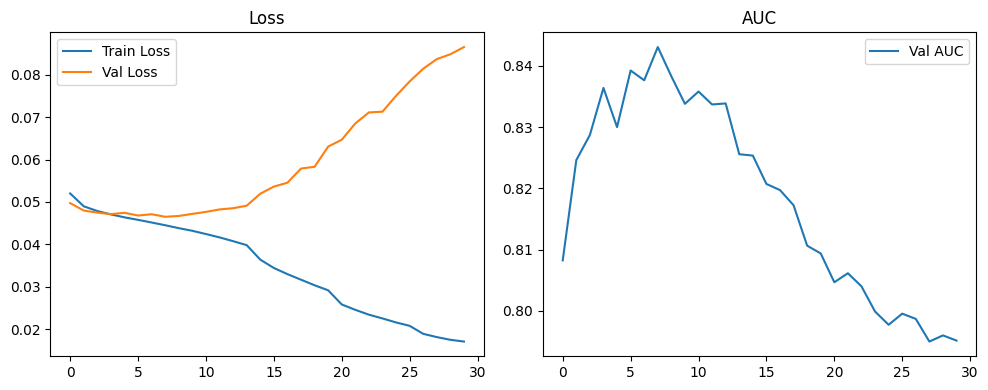

In [14]:
# ---------------- PLOT ----------------
plt.figure(figsize=(10,4))
plt.subplot(1,2,1)
plt.plot(history['train_loss'], label='Train Loss')
plt.plot(history['val_loss'], label='Val Loss')
plt.legend(); plt.title("Loss")
plt.subplot(1,2,2)
plt.plot(history['val_auc'], label='Val AUC')
plt.legend(); 
plt.title("AUC")
plt.tight_layout()
plt.savefig(SAVE_PATH/"training_plot.png")
print("Training plot saved.")

In [15]:
# -------------------------------------------------------
# 1. Imports
# -------------------------------------------------------
import torch
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import (
    confusion_matrix,
    classification_report,
    f1_score,
    precision_score,
    recall_score
)
from tqdm import tqdm

In [16]:
# -------------------------------------------------------
# 2. Set Model & Device
# -------------------------------------------------------
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)
model.eval()

DenseNet(
  (features): Sequential(
    (conv0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (norm0): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu0): ReLU(inplace=True)
    (pool0): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (denseblock1): _DenseBlock(
      (denselayer1): _DenseLayer(
        (norm1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu1): ReLU(inplace=True)
        (conv1): Conv2d(64, 128, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (norm2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu2): ReLU(inplace=True)
        (conv2): Conv2d(128, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      )
      (denselayer2): _DenseLayer(
        (norm1): BatchNorm2d(96, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu

In [17]:
# -------------------------------------------------------
# 3. Gather Predictions on Test Set
# -------------------------------------------------------
y_true, y_pred = [], []

with torch.no_grad():
    for images, labels in tqdm(test_loader, desc="Evaluating"):
        images = images.to(device)
        labels = labels.to(device)

        outputs = model(images)
        preds = torch.argmax(outputs, dim=1)

        y_true.extend(labels.cpu().numpy())
        y_pred.extend(preds.cpu().numpy())

y_true = np.array(y_true)
y_pred = np.array(y_pred)

Evaluating: 100%|████████████████████████████████████████████████████████████████████| 701/701 [03:12<00:00,  3.64it/s]


In [18]:
# -------------------------------------------------------
# 4. Define Class Names (VERY IMPORTANT)
# -------------------------------------------------------
# If you used ImageFolder or a custom Dataset, use its classes attribute:
# class_names = train_dataset.classes  
# or manually define:
class_names = [
    "Atelectasis", "Effusion", "Infiltration", "No Finding",
    "Consolidation", "Nodule", "Mass", "Cardiomegaly", "Pneumothorax",
    "Edema", "Emphysema", "Pleural_Thickening", "Fibrosis",
    "Pneumonia", "Hernia"
]

In [19]:
y_true = np.array(y_true)
y_pred = np.array(y_pred)

# ✅ Ensure both arrays are 2D
if y_true.ndim == 1:
    y_true = np.eye(len(class_names))[y_true]

# ✅ Convert logits/probabilities to binary using 0.5 threshold
if y_pred.ndim == 1:
    y_pred_bin = np.eye(len(class_names))[y_pred]
elif y_pred.ndim == 2 and not np.array_equal(y_pred, y_pred.astype(bool)):
    y_pred_bin = (y_pred > 0.5).astype(int)
else:
    y_pred_bin = y_pred.astype(int)

# ✅ Align shape
min_len = min(len(y_true), len(y_pred_bin))
y_true = y_true[:min_len]
y_pred_bin = y_pred_bin[:min_len]

print("\nClassification Report (Multi-Label):")
print(classification_report(y_true, y_pred_bin, target_names=class_names, zero_division=0))

# ✅ Weighted metrics
f1 = f1_score(y_true, y_pred_bin, average='weighted', zero_division=0)
precision = precision_score(y_true, y_pred_bin, average='weighted', zero_division=0)
recall = recall_score(y_true, y_pred_bin, average='weighted', zero_division=0)

print(f"\nF1 Score: {f1:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")


Classification Report (Multi-Label):
                    precision    recall  f1-score   support

       Atelectasis       0.68      0.86      0.76      6104
          Effusion       0.51      0.15      0.23      1107
      Infiltration       0.40      0.17      0.24       267
        No Finding       0.55      0.48      0.51      1332
     Consolidation       0.44      0.18      0.26      1947
            Nodule       0.47      0.25      0.33       561
              Mass       0.43      0.11      0.18       619
      Cardiomegaly       0.00      0.00      0.00       151
      Pneumothorax       0.52      0.28      0.36       515
             Edema       0.33      0.01      0.03       422
         Emphysema       0.33      0.11      0.17       220
Pleural_Thickening       0.42      0.30      0.35       220
          Fibrosis       0.21      0.07      0.11       165
         Pneumonia       0.30      0.09      0.14       327
            Hernia       0.53      0.56      0.54        18



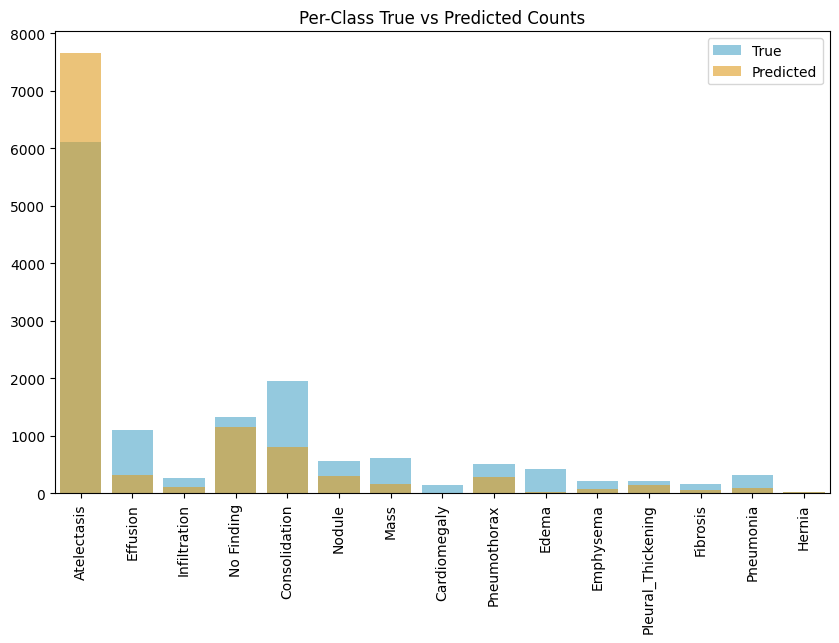

In [20]:
true_counts = y_true.sum(axis=0)
pred_counts = y_pred_bin.sum(axis=0)

plt.figure(figsize=(10, 6))
sns.barplot(x=class_names, y=true_counts, color="skyblue", label="True")
sns.barplot(x=class_names, y=pred_counts, color="orange", alpha=0.6, label="Predicted")
plt.xticks(rotation=90)
plt.title("Per-Class True vs Predicted Counts")
plt.legend()
plt.show()